# Tetrode processing

## Imports

In [1]:
import spikeinterface.full as si
import spikeinterface.widgets as sw
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface_gui
import probeinterface as pi
from probeinterface import generate_tetrode, ProbeGroup, generate_multi_shank
from probeinterface.plotting import plot_probe, plot_probegroup


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os

import warnings
warnings.simplefilter("ignore")

%matplotlib widget
print(f"SpikeInterface version: {si.__version__}")
np.set_printoptions(threshold=np.inf)


SpikeInterface version: 0.101.1


In [2]:
!kachery-cloud-init


This client has already been registered.
Click the following link to configure the client:
https://kachery-gateway.figurl.org/client/fb30a897dfc4f0381f7060224cdd868f789909b6e118c7a1d08696d8fc77ea9a

Client ID: fb30a897dfc4f0381f7060224cdd868f789909b6e118c7a1d08696d8fc77ea9a
Label: LAPTOP-BM2ADH0P
Owner: Gyrozaid

* Kachery-cloud is intended for collaborative sharing of data for scientific research. It should not be used for other purposes.


## Read in Data

In [3]:
path_to_data = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\raw\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\experiment1\\recording1"
full_raw_rec = si.read_openephys(path_to_data)


In [4]:
#raw data, seems to be stored in milliseconds
path_to_behavioral_data = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\raw\\behavioraldata\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA raw.csv"
behavioral_data = pd.read_csv(path_to_behavioral_data)
behavioral_data['TimeStamp'] = behavioral_data['TimeStamp'] / 1000
behavioral_data = behavioral_data.sort_values("TimeStamp")


In [5]:
path_to_behavioral_data_nathaniel = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\raw\\behavioraldata\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA Not Normalized.xlsx"
behavioral_data_nathaniel = pd.read_excel(path_to_behavioral_data_nathaniel)


In [6]:
#channel timestamps
path_to_timestamps = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\raw\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\experiment1\\recording1\\events\\Rhythm_FPGA-100.0\\TTL_1\\timestamps.npy"
timestamps = np.load(path_to_timestamps)

#channel timestamps stored in sample number, divide by 30,000 to get seconds
timestamps = timestamps / 30000

#event types
path_to_channels = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\raw\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\experiment1\\recording1\\events\\Rhythm_FPGA-100.0\\TTL_1\\channels.npy"
channels = np.load(path_to_channels)

#event types with states
path_to_channel_states = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\raw\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\experiment1\\recording1\\events\\Rhythm_FPGA-100.0\\TTL_1\\channel_states.npy"
channel_states = np.load(path_to_channel_states)

#no idea what this is but its in the data
path_to_full_words = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\raw\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\CPWI18_2019-07-29_13-50-50_LRRLLR 400uA\\experiment1\\recording1\\events\\Rhythm_FPGA-100.0\\TTL_1\\full_words.npy"
full_words = np.load(path_to_full_words)

In [7]:
vals = np.unique(np.abs(channel_states))

events = {}
for i, channel in enumerate(channel_states):
    if channel in events:
        events[channel].append(timestamps[i])
        continue
    
    events[channel] = [timestamps[i]]

events.keys()

dict_keys([2, -2, 6, -6, 4, -4, 5, -5, 1, -1])

### Raw Behavioral Data

In [8]:
#there seems to be channel errors. channels don't line up with nathaniels sorted data and it seems like trials last like a few milliseconds sometimes
behavioral_data

,ChannelV,TimeStamp
0,2,685.835500
1,-2,685.856233
524,6,686.845467
525,-6,686.856200
2,2,694.555333
...,...,...
1647,-6,8262.146667
2642,5,8262.225933
2643,-5,8264.236633
1648,6,8265.225867


### Nathaniels Behavioral Data

In [9]:
behavioral_data_nathaniel

,Unnamed: 0,Trial Start,Trial End,Seek Attempted,Seek P/F,Left Entries,Right Entries,Tones,Shock,Take,Take Time,Trial Block
0,0,686.845467,704.825133,False,NaN,NaN,"[694.5553333333334, 694.8053333333334]","[[694.5553333333334, 694.6556999999999]]",False,NaN,NaN,0
1,1,705.825100,730.924633,True,Pass,"[715.5049, 730.9246333333333]","[709.0850333333333, 713.4649666666667, 725.514...","[[709.0850666666666, 709.1854000000001], [713....",True,1.0,730.924633,0
2,2,740.704433,767.133900,False,NaN,[753.7741666666666],"[743.1044, 747.7243000000001]","[[743.1044, 743.2047333333333]]",False,NaN,NaN,0
3,3,768.323867,791.333467,True,Pass,"[773.2838, 791.3334666666667]","[770.8838333333334, 776.8537333333333, 779.273...","[[770.8838333333334, 770.9842], [776.853733333...",True,1.0,791.333467,0
4,4,801.143233,801.223233,True,Fail,[801.2232333333333],NaN,[],False,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...
244,244,8213.296900,8223.296700,False,NaN,NaN,NaN,[],False,NaN,NaN,0
245,245,8224.296667,8234.296467,False,NaN,NaN,NaN,[],False,NaN,NaN,0
246,246,8235.296467,8242.736333,True,Pass,[8242.736333333332],"[8235.826466666667, 8236.056466666667, 8237.78...","[[8235.826466666667, 8235.926833333333], [8236...",False,1.0,8242.736333,0
247,247,8252.066133,8262.065933,False,NaN,NaN,NaN,[],False,NaN,NaN,0


### Channel Behavioral Data

In [10]:
print(timestamps[2])
print(timestamps[3])

686.8454666666667
686.8562


In [11]:
print(channel_states[2])
print(channel_states[3])

6
-6


In [12]:
#haven't finished working this out, seems to be a mismatch
channel_map = {
    'trial_start': 6,
    'right_entry': 2,
    'tone': 4,
    
    
}

In [13]:

structured_events = []
for channel, timestamps in events.items():
    structured_array = np.zeros(len(timestamps), dtype=[('time', float), ('label', 'U10')])
    structured_array['time'] = timestamps
    structured_array['label'] = channel  # using channel as label
    structured_events.append(structured_array)



In [14]:
len(structured_events)

10

## Generate Probe Group

Need more info on the tetrode used to record this data. <br>


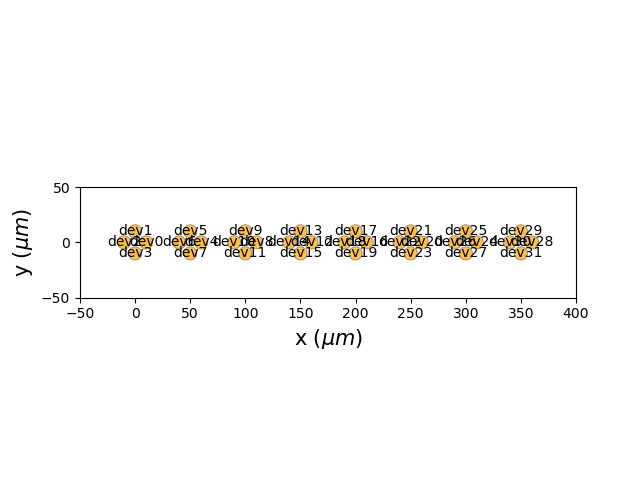

In [15]:
channel_names = list(full_raw_rec.get_channel_ids())
channel_ids = np.array([int(channel[2:]) - 1 for channel in channel_names])
probe_group = ProbeGroup()

for i in range(int(len(channel_names) / 4)):
    tetrode = generate_tetrode()
    tetrode.move([i * 50, 0])
    probe_group.add_probe(tetrode)
    
#probe_group.set_global_device_channel_indices(channel_ids)
probe_group.set_global_device_channel_indices([i for i in range(32)])
probe_group.auto_generate_contact_ids()
raw_rec = full_raw_rec.set_probegroup(probe_group, group_mode="by_probe")
plot_probegroup(probe_group, with_device_index=True, same_axes=True)


In [16]:
probe_group.get_global_contact_ids()

array(['70188222', '99946990', '23498729', '97903231', '54043317',
       '59079188', '14841934', '37124337', '94520752', '46810764',
       '72669236', '65312620', '50012754', '86523843', '26901469',
       '50609977', '89840886', '77647914', '89110444', '77822273',
       '68531898', '85470927', '99148751', '40048269', '23754157',
       '76528140', '23131600', '74257218', '53206495', '95994753',
       '10381177', '94654462'], dtype='<U64')

In [17]:
probe_group.get_global_device_channel_indices()

array([(0,  0), (0,  1), (0,  2), (0,  3), (1,  4), (1,  5), (1,  6),
       (1,  7), (2,  8), (2,  9), (2, 10), (2, 11), (3, 12), (3, 13),
       (3, 14), (3, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 20),
       (5, 21), (5, 22), (5, 23), (6, 24), (6, 25), (6, 26), (6, 27),
       (7, 28), (7, 29), (7, 30), (7, 31)],
      dtype=[('probe_index', '<i8'), ('device_channel_indices', '<i8')])

In [18]:
pi.io.write_prb("C:\\Users\\ryanz\\Documents\\NAc Analysis\\probe.prb", probe_group)

In [19]:
raw_rec.get_channel_groups()

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,
       5, 5, 6, 6, 6, 6, 7, 7, 7, 7], dtype=int64)

In [20]:
raw_rec.get_channel_ids()

array(['CH4', 'CH5', 'CH6', 'CH7', 'CH2', 'CH3', 'CH30', 'CH31', 'CH26',
       'CH27', 'CH28', 'CH29', 'CH22', 'CH23', 'CH24', 'CH25', 'CH18',
       'CH19', 'CH20', 'CH21', 'CH1', 'CH16', 'CH17', 'CH32', 'CH12',
       'CH13', 'CH14', 'CH15', 'CH8', 'CH9', 'CH10', 'CH11'], dtype='<U64')

## First Visualization: Trace

Visualize voltage fluctuations as a function of time <br>
Set mode to "line" for better visualization <br>
both raw data and filtered data (getting rid of natural voltage fluctuations) are overlayed on top of eachother

In [21]:
save_path = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\traces"
#remove noise
recording_f = si.bandpass_filter(raw_rec, freq_min=300, freq_max=9000)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')

#plot trace
w = si.plot_traces(recording_cmr, mode='line', time_range=[500, 520], backend="ipywidgets", events=structured_events[1], color_groups=True, show_channel_ids=True)

#this will be the recording we will use in future processing
recording_loaded = recording_cmr

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [22]:
#save recording with noise removed
#recording_saved = recording_loaded.save(folder=save_path + "\\test_trace")

In [23]:
#restore recording
#recording_loaded = si.load_extractor("C:\\Users\\ryanz\\Documents\\NAc Analysis\\traces\\test_trace")

In [24]:
recording_split = recording_loaded.split_by(property='group')


In [25]:
recording_split

{0: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 241,218,600 samples 
                        8,040.62s (2.23 hours) - int16 dtype - 1.80 GiB,
 1: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 241,218,600 samples 
                        8,040.62s (2.23 hours) - int16 dtype - 1.80 GiB,
 2: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 241,218,600 samples 
                        8,040.62s (2.23 hours) - int16 dtype - 1.80 GiB,
 3: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 241,218,600 samples 
                        8,040.62s (2.23 hours) - int16 dtype - 1.80 GiB,
 4: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 241,218,600 samples 
                        8,040.62s (2.23 hours) - int16 dtype - 1.80 GiB,
 5: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segments - 241,218,600 samples 
                        8,040.62s (2.23 hours) - int16 dtype - 1.80 GiB,
 6: ChannelSliceRecording: 4 channels - 30.0kHz - 1 segmen

In [26]:
recording_loaded = recording_split[0]

## Removing bad channels

In [27]:
#%matplotlib widget
#bad_channel_ids, channel_labels = si.detect_bad_channels(recording_f, method='coherence+psd')
#print('bad_channel_ids', bad_channel_ids)
#print('channel_labels', channel_labels)
#recording_good_channels_f = recording_f.remove_channels(bad_channel_ids)
#recording_good_channels = si.common_reference(recording_good_channels_f, reference='global', operator='median')

#print(recording_good_channels)
#print(recording_good_channels.channel_ids)

#w = si.plot_traces(recording_good_channels, mode='line', time_range=[18.5, 19], backend="ipywidgets", events=np.array([18.6]), color_groups=True, show_channel_ids=True)

#recording_loaded = recording_good_channels

## Sorting Spikes

In [28]:
#only take the first 60 seconds for processing speed purposes: need to set up cuda to run with GPU
#fs = recording_loaded.get_sampling_frequency()
#recording_sub = recording_loaded.frame_slice(start_frame=0*fs, end_frame=60*fs)


### comment out to use previously loaded sorting

In [29]:
#sort spikes
#save_path = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\sorted"
#sorted_recording = si.run_sorter(sorter_name='spykingcircus2', recording=recording_loaded, remove_existing_folder=True, output_folder=save_path + "\\test_sorted", verbose=True)

#sorted_recordings = si.run_sorter("spykingcircus2", recording_loaded, folder='sorted_tetrode_0', remove_existing_folder = True, verbose=True)

### load saved sorted object

In [30]:
save_path = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\sorted_tetrode_0"
sorted_recording = si.read_sorter_folder(save_path)

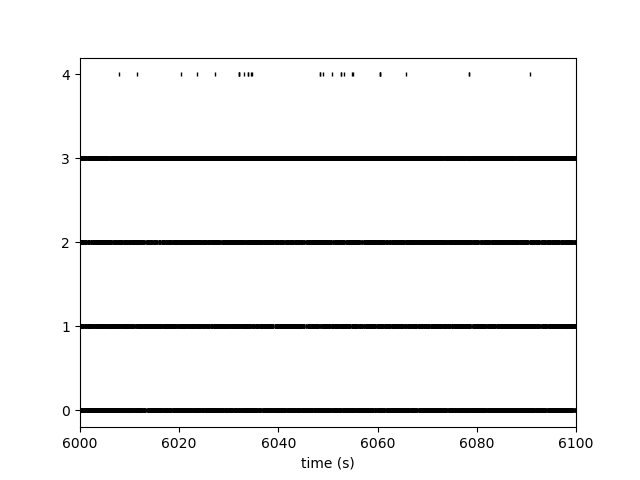

In [51]:
#plot rasters
w_rs = si.plot_rasters(sorted_recording, time_range=(6000,6100), backend="matplotlib")


In [32]:
#create and save sorting analyzer object. comment to just load already saved sorting analyzer
#save_path = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\waveforms"
#sorting_analyzer = si.create_sorting_analyzer(sorted_recording, 
#                                              recording_loaded, 
#                                              folder=save_path + "\\test_waveforms",
#                                              format="binary_folder",
#                                              sparse=False, 
#                                              overwrite=True)


In [33]:
#comment if already computed
#sorting_analyzer.compute(["random_spikes", "waveforms", 'correlograms', 'spike_amplitudes', 
#                          'templates','unit_locations', 'template_similarity', 'noise_levels', 
#                          'isi_histograms', 'principal_components', 'quality_metrics', 'spike_locations'])


In [34]:
#load sorting analyzer object
save_path = "C:\\Users\\ryanz\\Documents\\NAc Analysis\\waveforms"
sorting_analyzer = si.load_sorting_analyzer(folder=save_path + "\\test_waveforms")


In [35]:
sw.plot_sorting_summary(sorting_analyzer, curation=True, backend='sortingview')

https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://405a14beee6d6ac7946e26f25dc86c04ec3ea01e


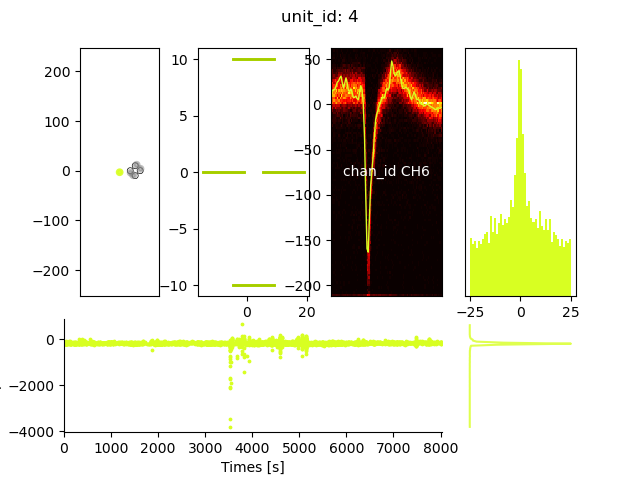

In [48]:
si.plot_unit_summary(sorting_analyzer, unit_id=4)

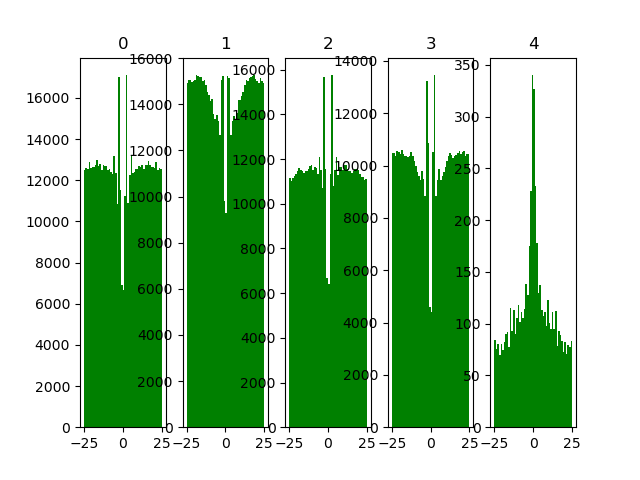

In [37]:
sw.plot_autocorrelograms(sorting_analyzer)

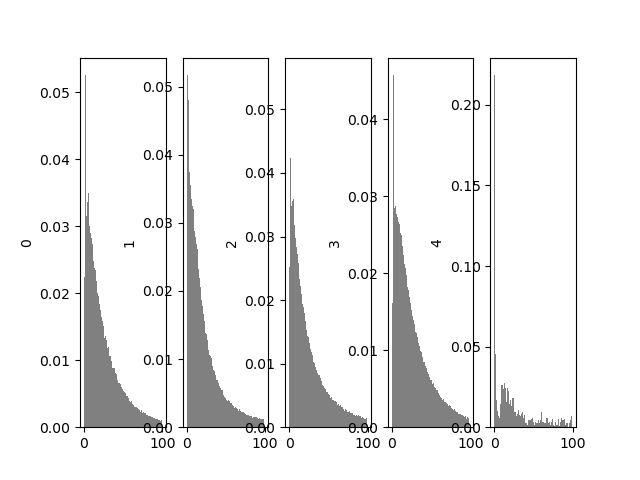

In [38]:
sw.plot_isi_distribution(sorted_recording, unit_ids=[0,1,2,3,4])

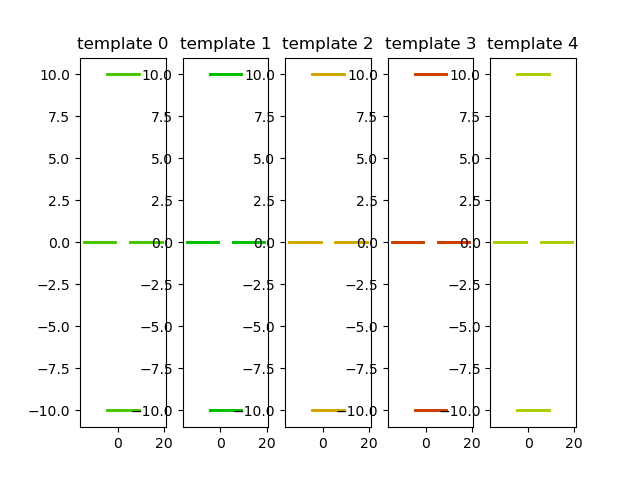

In [39]:
sw.plot_unit_waveforms(sorting_analyzer, unit_ids=[0,1,2,3,4])

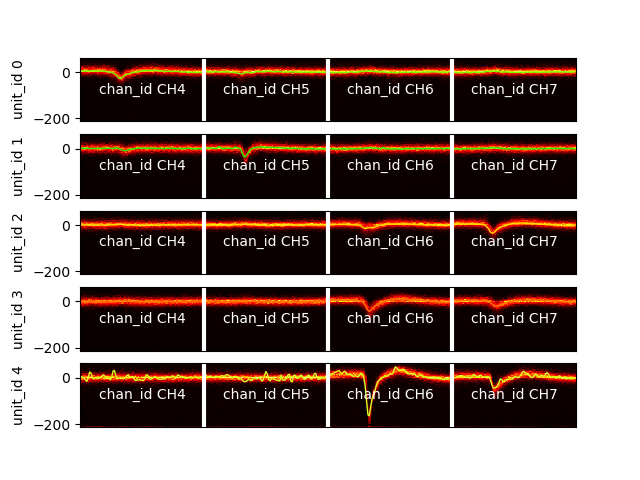

In [40]:
sw.plot_unit_waveforms_density_map(sorting_analyzer, unit_ids=[0,1,2,3,4])

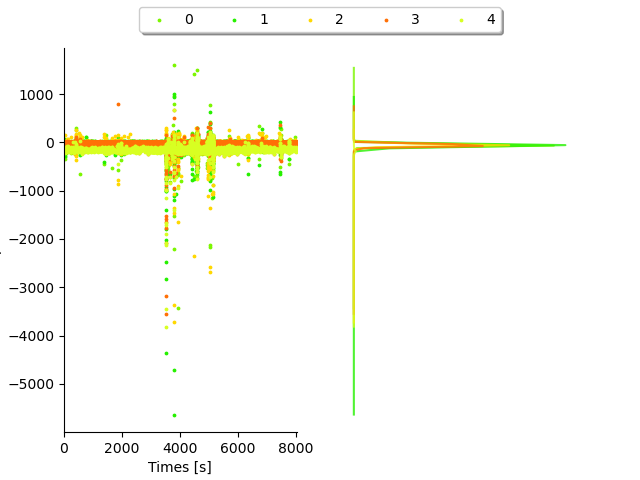

In [41]:
sw.plot_amplitudes(sorting_analyzer, plot_histograms=True)

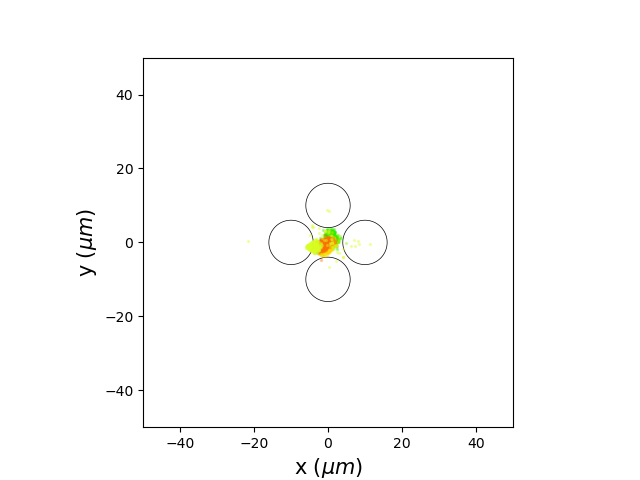

In [42]:
sw.plot_spike_locations(sorting_analyzer)

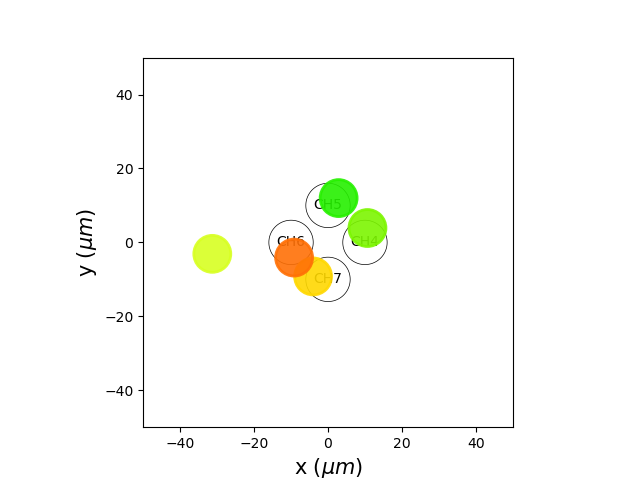

In [43]:
sw.plot_unit_locations(sorting_analyzer, with_channel_ids=True)

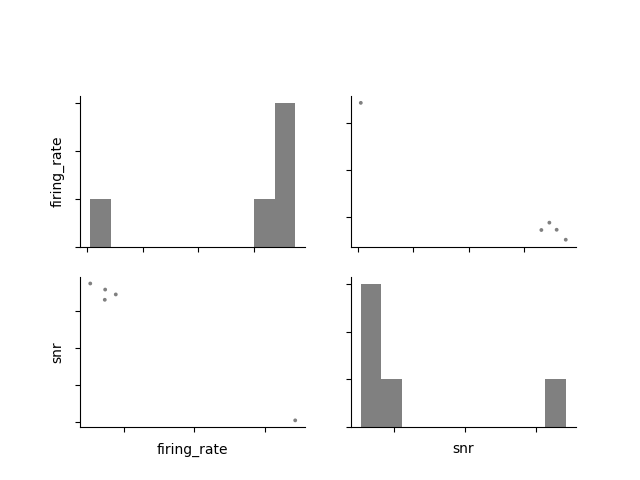

In [44]:
si.plot_quality_metrics(
    sorting_analyzer,
    include_metrics=['firing_rate', 'snr']
)

In [45]:
spike_vector = sorted_recording.to_spike_vector()


In [46]:
len(spike_vector)


1135923

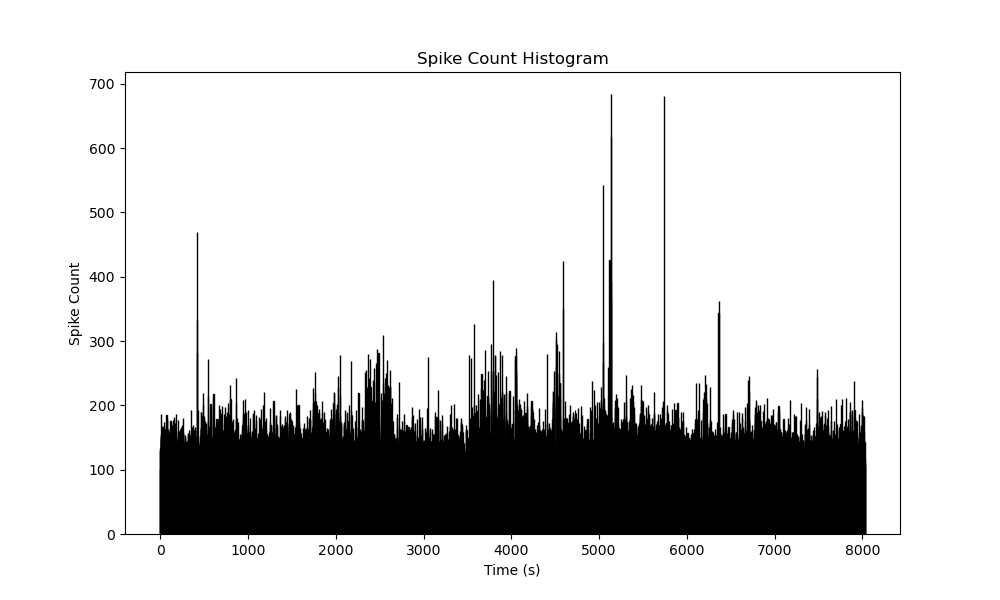

In [47]:
spike_vector = sorted_recording.to_spike_vector()
units = np.unique(spike_vector['unit_index'])

bin_edges = np.arange(0, 8028, 1)
spike_counts = np.zeros(len(bin_edges) - 1)

for unit in units:
    spike_times = spike_vector['sample_index'][spike_vector['unit_index'] == unit] / sorted_recording.get_sampling_frequency() 
    spike_counts_per_unit, _ = np.histogram(spike_times, bins=bin_edges)
    spike_counts += spike_counts_per_unit  

plt.figure(figsize=(10, 6))
plt.bar(bin_edges[:-1], spike_counts, width=1, edgecolor='black', align='edge')
plt.xlabel('Time (s)')
plt.ylabel('Spike Count')
plt.title('Spike Count Histogram')
plt.show()
